In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import joblib
from typing import Any
sys.path.insert(0, os.path.abspath('..'))

from src.feature_engineer import load_encoder
from src.model_utils import evaulate_model, train_model
from src.visualize_utils import plot_cm, get_avg_fold

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import torch.nn as nn
import torch
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
raw_path = "../data/raw"
encoder_path = "../models/label_encoder.pkl"

In [2]:
np.linalg.norm(np.array([1, 2, 3]))

np.float64(3.7416573867739413)

In [44]:
# preprocess
full_df = pd.merge(
    left=pd.read_csv(os.path.join(raw_path, "train.csv")),
    right=pd.read_csv(os.path.join(raw_path, "train_demographics.csv")),
    on="subject",
    how="left",
)

full_df

,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,...,tof_5_v61,tof_5_v62,tof_5_v63,adult_child,age,sex,handedness,height_cm,shoulder_to_wrist_cm,elbow_to_wrist_cm
0,SEQ_000007_000000,Target,SEQ_000007,0,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.683594,...,-1.0,-1.0,-1.0,0,12,1,1,163.0,52,24.0
1,SEQ_000007_000001,Target,SEQ_000007,1,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.949219,...,-1.0,-1.0,-1.0,0,12,1,1,163.0,52,24.0
2,SEQ_000007_000002,Target,SEQ_000007,2,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.722656,...,-1.0,-1.0,-1.0,0,12,1,1,163.0,52,24.0
3,SEQ_000007_000003,Target,SEQ_000007,3,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.601562,...,-1.0,-1.0,-1.0,0,12,1,1,163.0,52,24.0
4,SEQ_000007_000004,Target,SEQ_000007,4,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.566406,...,-1.0,-1.0,-1.0,0,12,1,1,163.0,52,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574940,SEQ_065531_000048,Non-Target,SEQ_065531,48,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.503906,...,-1.0,-1.0,71.0,1,30,0,1,186.0,55,30.0
574941,SEQ_065531_000049,Non-Target,SEQ_065531,49,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.773438,...,-1.0,-1.0,-1.0,1,30,0,1,186.0,55,30.0
574942,SEQ_065531_000050,Non-Target,SEQ_065531,50,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.082031,...,-1.0,-1.0,-1.0,1,30,0,1,186.0,55,30.0
574943,SEQ_065531_000051,Non-Target,SEQ_065531,51,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.964844,...,-1.0,-1.0,-1.0,1,30,0,1,186.0,55,30.0


In [45]:
def get_fft_power(signal: pd.Series):
    fft = np.fft.fft(signal)
    power = np.abs(fft) ** 2
    power = power // 2

    return power

In [64]:
non_target_gestures = full_df[full_df['sequence_type'] == 'Non-Target']['gesture'].unique()
target_gestures = full_df[full_df['sequence_type'] == 'Target']['gesture'].unique()

filtered_df = full_df[full_df["phase"] == "Gesture"]
filtered_df.loc[filtered_df['sequence_type'] == 'Non-Target', 'gesture'] = non_target_gestures[0]

cols_of_interest = ['acc_x', 'acc_y', 'acc_z']

for col in cols_of_interest:
    filtered_df[f'fft_{col}'] = filtered_df.groupby('sequence_id')[col].transform(get_fft_power)

filtered_df['acc_mag'] = np.sqrt(filtered_df['acc_x'] ** 2 + filtered_df['acc_y'] ** 2 + filtered_df['acc_z'] ** 2)
filtered_df['jerk_acc_x'] = filtered_df.groupby('sequence_id')['acc_x'].diff()
filtered_df['jerk_acc_y'] = filtered_df.groupby('sequence_id')['acc_y'].diff()
filtered_df['jerk_acc_z'] = filtered_df.groupby('sequence_id')['acc_z'].diff()

filtered_df

/tmp/ipykernel_34659/735782835.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[f'fft_{col}'] = filtered_df.groupby('sequence_id')[col].transform(get_fft_power)
/tmp/ipykernel_34659/735782835.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[f'fft_{col}'] = filtered_df.groupby('sequence_id')[col].transform(get_fft_power)
/tmp/ipykernel_34659/735782835.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,...,height_cm,shoulder_to_wrist_cm,elbow_to_wrist_cm,fft_acc_x,fft_acc_y,fft_acc_z,acc_mag,jerk_acc_x,jerk_acc_y,jerk_acc_z
25,SEQ_000007_000025,Target,SEQ_000007,25,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,7.027344,...,163.0,52,24.0,24206.0,16287.0,9289.0,9.924192,NaN,NaN,NaN
26,SEQ_000007_000026,Target,SEQ_000007,26,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,6.984375,...,163.0,52,24.0,37.0,65.0,209.0,10.113299,-0.042969,0.117188,0.343750
27,SEQ_000007_000027,Target,SEQ_000007,27,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,7.027344,...,163.0,52,24.0,63.0,11.0,54.0,10.536305,0.042969,-0.152344,0.957031
28,SEQ_000007_000028,Target,SEQ_000007,28,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,6.488281,...,163.0,52,24.0,9.0,0.0,52.0,9.782531,-0.539062,0.343750,-1.187500
29,SEQ_000007_000029,Target,SEQ_000007,29,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,6.988281,...,163.0,52,24.0,0.0,0.0,2.0,9.925453,0.500000,0.191406,-0.765625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574940,SEQ_065531_000048,Non-Target,SEQ_065531,48,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.503906,...,186.0,55,30.0,1.0,2.0,32.0,9.150011,-0.078125,0.308594,0.761719
574941,SEQ_065531_000049,Non-Target,SEQ_065531,49,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.773438,...,186.0,55,30.0,4.0,2.0,0.0,9.972424,0.269531,-0.230469,-0.765625
574942,SEQ_065531_000050,Non-Target,SEQ_065531,50,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.082031,...,186.0,55,30.0,14.0,0.0,13.0,8.021313,-0.691406,0.882812,1.804688
574943,SEQ_065531_000051,Non-Target,SEQ_065531,51,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.964844,...,186.0,55,30.0,4.0,0.0,8.0,9.919849,0.882812,-0.578125,-1.683594


In [65]:
agg_recipe = {
    "gesture": ["first"],
    "subject": ["first"],
    # acc
    "acc_x": ["mean", "std"],
    "acc_y": ["mean", "std"],
    "acc_z": ["mean", "std"],
    # mag
    "acc_mag": ["mean", "std"],
    # jerk
    "jerk_acc_x": ["mean", "std", "min", "max"],
    "jerk_acc_y": ["mean", "std", "min", "max"],
    "jerk_acc_z": ["mean", "std", "min", "max"],
    # fft stuff
    "fft_acc_x": ["mean", "std"],
    "fft_acc_y": ["mean", "std"],
    "fft_acc_z": ["mean", "std"],
}

filtered_df = filtered_df.groupby("sequence_id")[list(agg_recipe.keys())].agg(agg_recipe)  # type: ignore
filtered_df.columns = ["_".join(col).strip() if col[1] else col[0] for col in filtered_df.columns.values]
filtered_df = filtered_df.rename(
    columns={
        "gesture_first": "target",
        "subject_first": "subject",
    }
)

# encoder
target_df = filtered_df["target"]
subject_df = filtered_df["subject"]
encoder = load_encoder(encoder_path, target_df)

target_tensor = torch.tensor(encoder.transform(target_df), dtype=torch.long)
features_tensor = torch.tensor(filtered_df.drop(columns=["target", "subject"]).to_numpy(), dtype=torch.float32)
target_gestures_encoded = torch.tensor(encoder.transform(target_gestures))

filtered_df

,target,subject,acc_x_mean,acc_x_std,acc_y_mean,acc_y_std,acc_z_mean,acc_z_std,acc_mag_mean,acc_mag_std,...,jerk_acc_z_mean,jerk_acc_z_std,jerk_acc_z_min,jerk_acc_z_max,fft_acc_x_mean,fft_acc_x_std,fft_acc_y_mean,fft_acc_y_std,fft_acc_z_mean,fft_acc_z_std
sequence_id,,,,,,,,,,,,,,,,,,,,,
SEQ_000007,Cheek - pinch skin,SUBJ_059520,6.875854,0.779424,5.640137,0.582177,4.259521,1.247767,9.977855,0.320601,...,-0.007434,0.863112,-2.644531,1.609375,765.343750,4277.463709,513.843750,2878.316781,313.968750,1638.559763
SEQ_000008,Forehead - pull hairline,SUBJ_020948,3.449929,0.736728,7.261364,0.824113,5.647609,1.740919,9.993138,0.900278,...,-0.082397,2.908491,-6.011719,4.632812,204.484848,1126.607577,880.424242,4995.904442,574.090909,3014.997112
SEQ_000013,Cheek - pinch skin,SUBJ_040282,-7.591276,1.143683,3.751562,0.571292,-5.493620,0.968642,10.189387,0.750752,...,0.006600,0.713308,-1.683594,1.875000,882.933333,4731.068137,215.300000,1155.473277,465.700000,2477.217936
SEQ_000016,Write name on leg,SUBJ_052342,5.291590,0.940102,-4.744830,0.441674,-6.674517,1.942150,9.967680,0.655484,...,0.341264,2.048119,-0.843750,11.531250,490.029412,2773.065665,385.470588,2231.053661,819.029412,4405.039053
SEQ_000018,Forehead - pull hairline,SUBJ_032165,6.235639,0.241211,6.068704,0.211266,4.739890,0.455216,9.921320,0.220616,...,0.056937,0.245389,-0.648438,0.726562,661.558824,3854.160555,626.441176,3650.628217,384.794118,2226.410248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SEQ_065508,Write name on leg,SUBJ_027682,-7.286932,0.393596,6.254498,0.255871,-2.798177,0.333119,10.011920,0.367127,...,-0.014404,0.455965,-1.265625,0.917969,878.121212,5032.574458,646.060606,3707.745389,130.515152,741.855618
SEQ_065519,Neck - scratch,SUBJ_050642,0.811458,0.862646,9.518099,0.245501,-3.321224,0.503772,10.158976,0.323785,...,0.019801,0.685541,-1.261719,1.300781,20.233333,61.661301,1359.500000,7442.888565,168.700000,905.507598
SEQ_065522,Above ear - pull hair,SUBJ_040282,-9.020573,0.501440,-3.511719,0.813275,-1.737630,0.814991,9.892560,0.630282,...,0.006600,1.168052,-2.527344,2.683594,1223.700000,6684.539322,194.066667,1011.466669,54.400000,246.400655


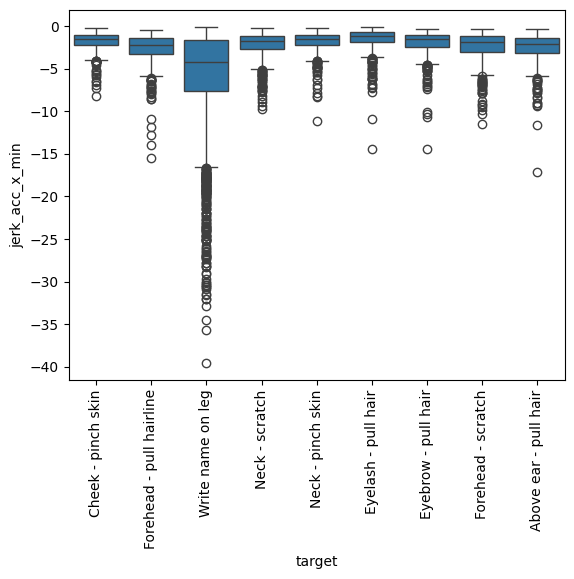

In [72]:
sns.boxplot(filtered_df, x='target', y='jerk_acc_x_min')
# plt.ylim(-0.1, 0.1)
plt.xticks(rotation=90)
print()

In [73]:
class SimpleModel(nn.Module):
    def __init__(self, n_input, n_classes):
        super().__init__()

        self.fc = nn.Sequential(
            nn.Linear(n_input, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, n_classes),
        )

    def forward(self, x: torch.Tensor):
        y_pred = self.fc(x)

        return y_pred

In [74]:
batch_size = 64
n_epochs = 200
n_splits = 5

gkf = GroupKFold(n_splits)

test_subjects = []
folds_score = []
for fold, (train_indices, test_indices) in enumerate(gkf.split(X=features_tensor, y=target_tensor, groups=subject_df)): # type: ignore
    test_subjects.append(subject_df[test_indices].unique())
    X_train, y_train = features_tensor[train_indices], target_tensor[train_indices]
    X_test, y_test = features_tensor[test_indices], target_tensor[test_indices]
    
    scalar = StandardScaler()
    X_train = torch.tensor(scalar.fit_transform(X_train.numpy()), dtype=torch.float32)
    X_test = torch.tensor(scalar.transform(X_test), dtype=torch.float32)
    
    dataset_train = TensorDataset(X_train, y_train)
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True) # uh not sure if i should keep shuffle or no
    
    model = SimpleModel(X_train.shape[1], len(encoder.classes_)).to(device)
    
    model.train()
    train_model(model, dataloader_train, n_epochs, True)

    model.eval()
    score_dashboard = evaulate_model(model, X_test, y_test, target_gestures_encoded, encoder)
    folds_score.append(score_dashboard)

/tmp/ipykernel_34659/1917683516.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_subjects.append(subject_df[test_indices].unique())


0 - loss_avg: 1.8076123232934989
20 - loss_avg: 1.1422921278897453
40 - loss_avg: 1.0167183846819634
60 - loss_avg: 0.9309009360332116
80 - loss_avg: 0.8644233532980377
100 - loss_avg: 0.8012115844324523
120 - loss_avg: 0.7532887634109048
140 - loss_avg: 0.7148533901747536
160 - loss_avg: 0.6764256533454446
180 - loss_avg: 0.6433753888396656


/tmp/ipykernel_34659/1917683516.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_subjects.append(subject_df[test_indices].unique())


0 - loss_avg: 1.7924874191190683
20 - loss_avg: 1.1529876788457234
40 - loss_avg: 1.0325357165991091
60 - loss_avg: 0.9563293860239142
80 - loss_avg: 0.8965646683001051
100 - loss_avg: 0.8374483655480778
120 - loss_avg: 0.7853144842619989
140 - loss_avg: 0.7428350293753194
160 - loss_avg: 0.7009965283613578
180 - loss_avg: 0.6629788285376979


/tmp/ipykernel_34659/1917683516.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_subjects.append(subject_df[test_indices].unique())


0 - loss_avg: 1.8327077755741044
20 - loss_avg: 1.1603901853748397
40 - loss_avg: 1.0373938586197646
60 - loss_avg: 0.9560493698307112
80 - loss_avg: 0.8852797764189103
100 - loss_avg: 0.8317653016716826
120 - loss_avg: 0.7926566489771301
140 - loss_avg: 0.743293321015788
160 - loss_avg: 0.7085080167242125
180 - loss_avg: 0.6821197376531714


/tmp/ipykernel_34659/1917683516.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_subjects.append(subject_df[test_indices].unique())


0 - loss_avg: 1.8119044105211894
20 - loss_avg: 1.155157695798313
40 - loss_avg: 1.0412357391095628
60 - loss_avg: 0.9618819963698294
80 - loss_avg: 0.8978643312173731
100 - loss_avg: 0.8483834617278155
120 - loss_avg: 0.8008121871480754
140 - loss_avg: 0.7572605528083503
160 - loss_avg: 0.7166629436553693
180 - loss_avg: 0.6837629722613915


/tmp/ipykernel_34659/1917683516.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_subjects.append(subject_df[test_indices].unique())


0 - loss_avg: 1.8066488492722605
20 - loss_avg: 1.1519157039184196
40 - loss_avg: 1.0247171848428016
60 - loss_avg: 0.9364615450887119
80 - loss_avg: 0.8722068047990986
100 - loss_avg: 0.8172810255896812
120 - loss_avg: 0.7718502101944942
140 - loss_avg: 0.7264171663452598
160 - loss_avg: 0.6841308509602266
180 - loss_avg: 0.6524960886613995


macro: 0.39, binary: 0.90, competition: 0.65


,precision,recall,f1-score,support
Above ear - pull hair,0.358915,0.377852,0.363768,127.600000
Cheek - pinch skin,0.337132,0.298298,0.312493,127.400000
Eyebrow - pull hair,0.295199,0.275794,0.283377,127.600000
Eyelash - pull hair,0.406860,0.440625,0.420233,128.000000
Forehead - pull hairline,0.349192,0.329688,0.333295,128.000000
Forehead - scratch,0.429015,0.432812,0.427168,128.000000
Neck - pinch skin,0.276876,0.278125,0.275918,128.000000
Neck - scratch,0.284322,0.231250,0.254845,128.000000
Write name on leg,0.823467,0.853183,0.838004,607.400000
accuracy,0.526873,0.526873,0.526873,0.526873


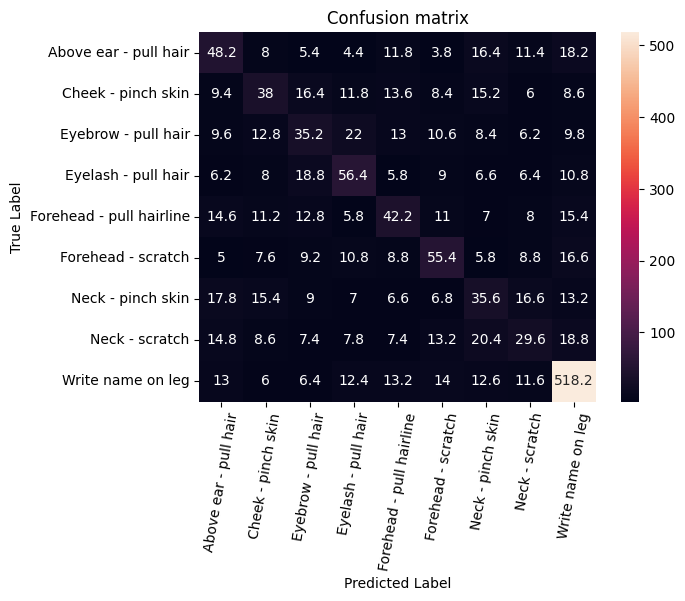

In [76]:
fold = get_avg_fold(folds_score)
# fold = folds_score[0]

macro = fold["f1_macro"]
binary = fold["f1_binary"]
competition_eval = fold["competition_evaluation"]
cm = fold['confusion_matrix']

print(f'macro: {macro:.2f}, binary: {binary:.2f}, competition: {competition_eval:.2f}')


plot_cm(cm, list(encoder.classes_))
fold["classification_report"]

In [ ]:
# final train model
n_epochs = 400
model = SimpleModel(len(encoder.classes_))

dataset_all = TensorDataset(features_tensor, target_tensor)
dataloader_all = DataLoader(dataset_all, batch_size=batch_size, shuffle=True)

train_model(model, dataloader_all, n_epochs, should_log=True)
torch.save(model.state_dict, '../models/model.pth')

0 - loss_avg: 1.7670864285901189
20 - loss_avg: 1.3435163935646415
40 - loss_avg: 1.2941331644542515
60 - loss_avg: 1.2580602089874446
80 - loss_avg: 1.2367916163057089
100 - loss_avg: 1.2189869447611272
120 - loss_avg: 1.2041548932902515
140 - loss_avg: 1.1891458523459733
160 - loss_avg: 1.1784265250898898
180 - loss_avg: 1.1631644000299275
200 - loss_avg: 1.1489455755800009
220 - loss_avg: 1.1393039487302303
240 - loss_avg: 1.130943219177425
260 - loss_avg: 1.1241767010651529
280 - loss_avg: 1.1117427400313318
300 - loss_avg: 1.1023416174575686
320 - loss_avg: 1.0911986152641475
340 - loss_avg: 1.0916559724137187
360 - loss_avg: 1.0821397854015231
380 - loss_avg: 1.0796014992520213
